In [20]:
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.feature_selection import RFECV
from sklearn.model_selection import train_test_split, RandomizedSearchCV,GridSearchCV

import pandas as pd
import numpy as np
np.random.seed(74)
import os
import glob

In [21]:
# Get data
training_folder = os.path.join("..","..","ProcessedData","Training_Data_20231106")

csv_list = glob.glob(os.path.join(training_folder,"*"))
df_list = [pd.read_csv(csv,index_col=0) for csv in csv_list]

# Process data
df_total = pd.concat(df_list)
df_total.reset_index(drop=True)
df_total.replace([np.inf, -np.inf], np.nan, inplace=True)
df_total.dropna(axis=0,inplace=True)
df_total.drop(labels=["label","Filename","Region"],axis=1,inplace=True)

# Split
X = df_total.drop(labels="Labels",axis=1)
y = df_total["Labels"]
print(X.columns)

Index(['area', 'equivalent_diameter', 'orientation', 'major_axis_length',
       'minor_axis_length', 'perimeter', 'min_intensity', 'mean_intensity',
       'max_intensity', 'solidity', 'eccentricity', 'centroid_local-0',
       'centroid_local-1', 'feret_diameter_max', 'moments-0-0', 'moments-0-1',
       'moments-0-2', 'moments-0-3', 'moments-1-0', 'moments-1-1',
       'moments-1-2', 'moments-1-3', 'moments-2-0', 'moments-2-1',
       'moments-2-2', 'moments-2-3', 'moments-3-0', 'moments-3-1',
       'moments-3-2', 'moments-3-3', 'moments_central-0-0',
       'moments_central-0-1', 'moments_central-0-2', 'moments_central-0-3',
       'moments_central-1-0', 'moments_central-1-1', 'moments_central-1-2',
       'moments_central-1-3', 'moments_central-2-0', 'moments_central-2-1',
       'moments_central-2-2', 'moments_central-2-3', 'moments_central-3-0',
       'moments_central-3-1', 'moments_central-3-2', 'moments_central-3-3',
       'moments_hu-0', 'moments_hu-1', 'moments_hu-2', 'mo

In [22]:
# Remove size- and intensity-aware features
features_oi = [
                'solidity',
                'eccentricity',            
                'moments_hu-0',
                'moments_hu-1',
                'moments_hu-2',
                'moments_hu-3',
                'moments_hu-5',
                'major_axis_length/minor_axis_length',
                'perimeter/major_axis_length',
                'perimeter/minor_axis_length',
                'facet_score'
                ]
X = X[features_oi]

In [23]:
# Train-test sets
X_train, X_test, y_train, y_test = train_test_split(X,y,train_size=.7,stratify=y)


In [24]:
# Create grid search parameters
params = {"n_estimators": np.arange(2,240,8),
          "min_samples_leaf":np.arange(1,15,2)}

seeds = np.arange(5)

train_f1_arr = []
test_f1_arr = []

best_grid = None
for ii,seed in enumerate(seeds):
    clf = RandomForestClassifier()
    grid_search = RandomizedSearchCV(clf,params,n_iter=10,random_state=seed)
    grid_search = GridSearchCV(clf,param_grid=params,scoring="f1_macro")

    result = grid_search.fit(X_train,y_train)
    best_clf = result.best_estimator_ 

    pred_train = best_clf.predict(X_train)
    pred_test = best_clf.predict(X_test)

    train_f1 = metrics.f1_score(pred_train,y_train,average="macro")
    test_f1 = metrics.f1_score(pred_test,y_test,average="macro")
    
    if best_grid is None or test_f1 > np.max(test_f1_arr):
        best_grid = grid_search

    train_f1_arr.append(train_f1)
    test_f1_arr.append(test_f1)



In [25]:
best_grid.cv_results_

{'mean_fit_time': array([0.00601687, 0.01255078, 0.02164655, 0.03222151, 0.03990998,
        0.04950948, 0.05984602, 0.06925035, 0.07728972, 0.08598771,
        0.09355669, 0.10378056, 0.11130304, 0.122259  , 0.12776036,
        0.14160805, 0.15514984, 0.16103196, 0.16829062, 0.1751102 ,
        0.20314445, 0.19692259, 0.20226207, 0.20623479, 0.21835036,
        0.2256906 , 0.23201261, 0.24614902, 0.25119376, 0.26069908,
        0.00297637, 0.0109128 , 0.01895652, 0.02710061, 0.03605685,
        0.04445782, 0.05261779, 0.06209126, 0.07191443, 0.08112292,
        0.08828602, 0.09390063, 0.10537791, 0.11195235, 0.12073545,
        0.12666144, 0.13466859, 0.14533982, 0.15780973, 0.16298232,
        0.17478108, 0.18121719, 0.18855715, 0.19722877, 0.2047514 ,
        0.20973554, 0.2246891 , 0.23208694, 0.24050541, 0.25695367,
        0.00290084, 0.01110196, 0.01844602, 0.02584782, 0.03436141,
        0.04506016, 0.05177808, 0.05962129, 0.06874566, 0.07573342,
        0.08287668, 0.09165339,

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or R

Index(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time',
       'param_min_samples_leaf', 'param_n_estimators', 'params',
       'split0_test_score', 'split1_test_score', 'split2_test_score',
       'split3_test_score', 'split4_test_score', 'mean_test_score',
       'std_test_score', 'rank_test_score'],
      dtype='object')
Index(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time',
       'param_min_samples_leaf', 'param_n_estimators', 'params',
       'split0_test_score', 'split1_test_score', 'split2_test_score',
       'split3_test_score', 'split4_test_score', 'mean_test_score',
       'std_test_score', 'rank_test_score'],
      dtype='object')
Index(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time',
       'param_min_samples_leaf', 'param_n_estimators', 'params',
       'split0_test_score', 'split1_test_score', 'split2_test_score',
       'split3_test_score', 'split4_test_score', 'mean_test_score',
       'std_test_score', '

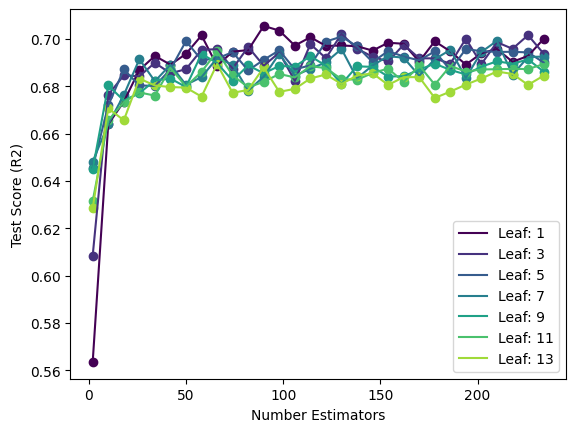

In [28]:
df_results = pd.DataFrame(best_grid.cv_results_)
df_results


unique_leafs = df_results.param_min_samples_leaf.unique()
import matplotlib.pyplot as plt 
cm = plt.get_cmap("viridis")
color_list = [cm(ii/len(unique_leafs)) for ii in range(len(unique_leafs))]
for ii,leaf_oi in enumerate(unique_leafs):
    c = color_list[ii]
    df_subset = df_results[df_results.param_min_samples_leaf==leaf_oi]
    print(df_subset.columns)
    plt.scatter(df_subset["param_n_estimators"],df_subset["mean_test_score"],c=c)

    plt.plot(df_subset["param_n_estimators"],df_subset["mean_test_score"],c=c,label=f"Leaf: {leaf_oi}")

    plt.xlabel("Number Estimators")
    plt.ylabel("Test Score (R2)")
plt.legend()
#plt.ylim([0,1])